### Mandatory import

In [3]:
#1# Mandatory libraries: 
import pandas as pd
import numpy as np
from amwag.app_utilities.preprocessing import *
import warnings

#2# PCA:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA ,FastICA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA()
le = LabelEncoder()

RSEED = 5

In [4]:
#3# Data visualization: 
import matplotlib.pyplot as plt
import seaborn as sns

### Preparing the dataframe:

In [5]:
df = pd.read_csv("data/AQUASTAT_complete.csv", index_col=0)

pre_split_processor = get_pre_split_processor()
df_pre = pre_split_processor.transform(df)

### Split train, validation and test sets:

In [6]:
targets = ['gdp_per_capita', 'water_stress', 'total_population_with_access_to_safe_drinking_water']

Y = df_pre[targets]
X = df_pre.drop(columns=targets)

X_train, X_pretest, Y_train, Y_pretest = train_test_split(X, Y, test_size=0.30, random_state=RSEED, stratify=X.country)
X_test, X_valid, Y_test, Y_valid = train_test_split(X_pretest, Y_pretest, test_size=0.50, random_state=RSEED, stratify=X_pretest.country)

In [7]:
full_preprocessor = get_full_preprocessor(X_train.columns.to_list(), hot=False)

X_train_pre = full_preprocessor.fit_transform(X_train)

d:\Spiced\Final_Project_Water_Management\amwag\app_utilities\preprocessing.py:212: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[col_list] = df[col_list].applymap(lambda x: x if x>=0 else 0) # make shure there are no negative values
d:\Spiced\Final_Project_Water_Management\amwag\app_utilities\preprocessing.py:213: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[col_list] = df[col_list].applymap(lambda x: np.log(x+1e-10))
d:\Spiced\Final_Project_Water_Management\amwag\app_utilities\preprocessing.py:217: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[col_list] = df[col_list].applymap(np.sqrt)
d:\Spiced\Final_Project_Water_Management\amwag\app_utilities\preprocessing.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[col_list] = df[col_list].applymap(lambda x: np.power(x, 1/3.))


- Removing the Country column for a better perfomance:

In [8]:
X_temp = X_train_pre.copy()
X_temp_without_country = X_temp.copy()
X_temp_without_country.drop(columns=['country', 'year'],inplace=True)
X_temp_without_country_sc = scaler.fit_transform(X_temp_without_country)

### PCA:

In [9]:
#calculate the explained variance ratio for each principal component:

X_pca = pca.fit_transform(X_temp_without_country_sc)
explained_variance_ratio = pca.explained_variance_ratio_

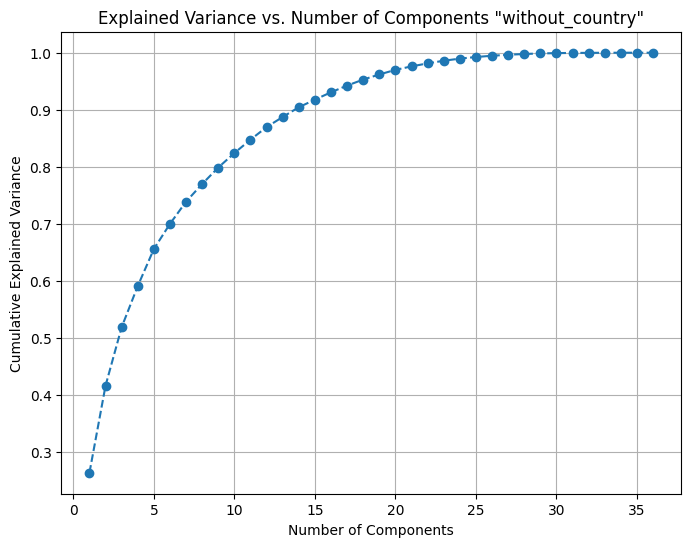

In [10]:
#plot the cumulative explained variance ratio:

cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components "without_country"')
plt.grid()
plt.show()

In [11]:
#determine the number of components to retain (e.g., 97% of variance)
n_components_to_retain = np.argmax(cumulative_variance >= 0.97) + 1
print(f'Number of components to retain for 97% variance: {n_components_to_retain}')

Number of components to retain for 97% variance: 21


In [12]:
#perform PCA again with the chosen number of components
pca = PCA(n_components=n_components_to_retain)
X_final = pca.fit_transform(X_temp_without_country_sc)

In [13]:
#standard PCA with year and country  
 
country_column = X_temp['country'].values 

encoded_country = le.fit_transform(country_column)

X_temp['encoded_country'] = encoded_country
X_temp_country_sc = X_temp.copy()
X_temp_country_sc.drop(columns=['country'],inplace=True)

#scale data

X_temp_country_sc = scaler.fit_transform(X_temp_country_sc)

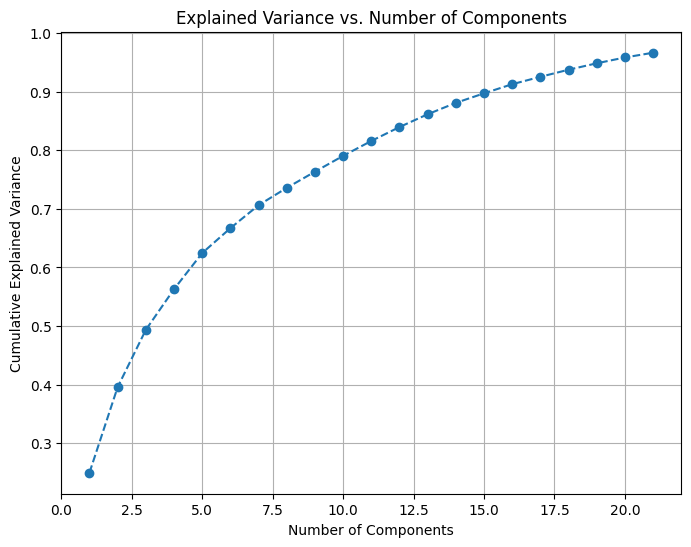

Number of components to retain for 95% variance: 1


In [14]:
X_pca = pca.fit_transform(X_temp_country_sc)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

n_components_to_retain = np.argmax(cumulative_variance >= 0.97) + 1
print(f'Number of components to retain for 95% variance: {n_components_to_retain}')

pca = PCA(n_components=n_components_to_retain)
X_final_country = pca.fit_transform(X_temp_country_sc)

### IPCA

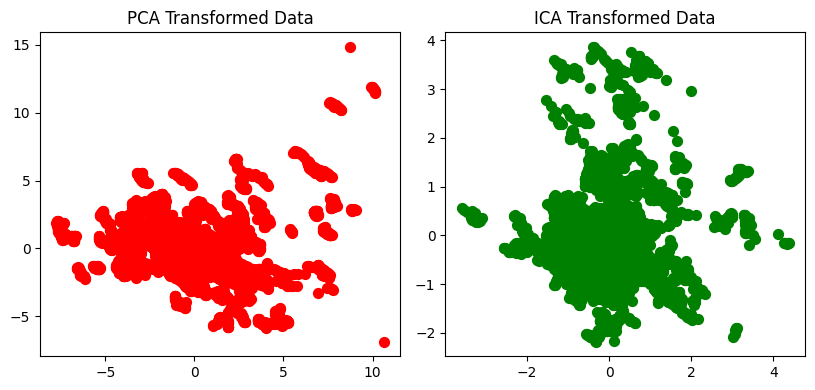

In [15]:
pca = PCA(n_components=19)
X_3_pca = pca.fit_transform(X_temp_without_country_sc)

# Perform ICA to separate independent components
ica = FastICA(n_components=10)
X_ica = ica.fit_transform(X_temp_without_country_sc)

# Plot the original data, PCA-transformed data, and ICA-transformed data
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 2)
plt.scatter(X_3_pca.iloc[:, 0], X_3_pca.iloc[:, 1], c='r', marker='o', s=50)
plt.title("PCA Transformed Data")

plt.subplot(1, 3, 3)
plt.scatter(X_ica.iloc[:, 0], X_ica.iloc[:, 1], c='g', marker='o', s=50)
plt.title("ICA Transformed Data")

plt.tight_layout()
plt.show()

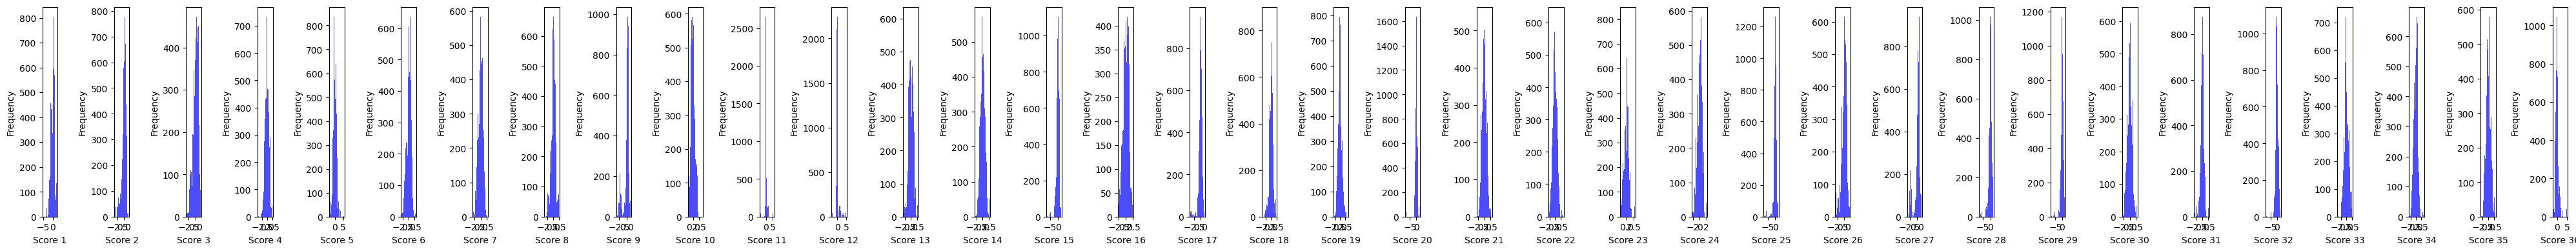

In [16]:
scores = np.dot(X_ica, ica.mixing_.T)

plt.figure(figsize=(40, 4))

for i in range(scores.shape[1]):
    plt.subplot(1, scores.shape[1], i + 1)
    plt.hist(scores[:, i], bins=30, color='b', alpha=0.7)
    plt.xlabel(f"Score {i + 1}")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()